In [1]:
import re
import random

# Let's do 2-way positive/negative classification instead of 5-way
def load_sst_data(path,
                  easy_label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(path) as f:
        for i, line in enumerate(f):
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue

            # Strip out the parse information and the phrase labels--
            # ---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data

sst_home = 'data/trees/'
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

# Note: Unlike with k-nearest neighbors, evaluation here should be fast, and we don't need to
# trim down the dev and test sets.

In [2]:
import collections
import numpy as np

def sentence_to_padded_index_sequence(datasets):
    '''Annotates datasets with feature vectors.'''


    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    SEQ_LEN = 20

    # Extract vocabulary
    def tokenize(string):
        return string.lower().split()

    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['text']))

    vocabulary = set([word for word in word_counter if word_counter[word] > 10])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary

    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}

    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)

            token_sequence = tokenize(example['text'])
            padding = SEQ_LEN - len(token_sequence)

            for i in range(SEQ_LEN):
                if i >= padding:
                    if token_sequence[i - padding] in word_indices:
                        index = word_indices[token_sequence[i - padding]]
                    else:
                        index = word_indices[UNKNOWN]
                else:
                    index = word_indices[PADDING]
                example['index_sequence'][i] = index
    return indices_to_words, word_indices

indices_to_words, word_indices = sentence_to_padded_index_sequence([training_set, dev_set, test_set])

In [3]:
print(training_set[12])
print(len(word_indices))

{'label': 1, 'text': 'The more you think about the movie , the more you will probably like it .', 'index_sequence': array([  0,   0,   0,   0, 479,  88, 401, 640,  65, 479, 510,  19, 479,
        88, 401, 886, 485, 777, 954, 507])}
1250


In [4]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1
    return correct / float(len(eval_set))

In [5]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [7]:
class RNNSentimentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.learning_rate = 1.0  # Should be about right
        self.training_epochs = 150  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 1  # How often to test and print out statistics
        self.dim = 12  # The dimension of the hidden state of the RNN
        self.embedding_dim = 8  # The dimension of the learned word embeddings
        self.batch_size = 256  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        self.l2_lambda = 0.001

        self.trainable_variables = []

        # Define the parameters
        self.E = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim], stddev=0.1))
        self.trainable_variables.append(self.E)

        self.W_rnn = tf.Variable(tf.random.normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_rnn = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
        self.trainable_variables.append(self.W_rnn)
        self.trainable_variables.append(self.b_rnn)

        self.W_cl = tf.Variable(tf.random.normal([self.dim, 2], stddev=0.1))
        self.b_cl = tf.Variable(tf.random.normal([2], stddev=0.1))
        self.trainable_variables.append(self.W_cl)
        self.trainable_variables.append(self.b_cl)

        # TODO1: Add additional GRU parameters

        # Update Gate parameters
        self.W_z = tf.Variable(tf.random.normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_z = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
        self.trainable_variables.append(self.W_z)
        self.trainable_variables.append(self.b_z)

        # Reset Gate parameters
        self.W_r = tf.Variable(tf.random.normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_r = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
        self.trainable_variables.append(self.W_r)
        self.trainable_variables.append(self.b_r)

    def model(self,x):
        # Split up the inputs into individual tensors
        self.x_slices = tf.split(x, self.sequence_length, 1)
        self.h_zero = tf.zeros([self.batch_size, self.dim])

        # Define one step of the RNN
        # TODO2: Modify the step() function to compute GRU step





        def step(x, h_prev):
            #print('Emb matrix dims: ', tf.Tensor([1250    8], shape=(2,), dtype=int32)
            emb = tf.nn.embedding_lookup(params=self.E,ids=x)
            #print('Emb dims: ', tf.shape(emb)) tf.Tensor([256   8], shape=(2,), dtype=int32)
            emb_h_prev = tf.concat([emb, h_prev], 1)
            #print('Emb concat dims: ', tf.shape(emb_h_prev)) tf.Tensor([256  20], shape=(2,), dtype=int32)

            # Update gate
            z = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_z) + self.b_z)
            #print('W_z dims: ', tf.shape(self.W_z)) tf.Tensor([20 12], shape=(2,), dtype=int32)
            #print('z dims: ', tf.shape(z)) tf.Tensor([256  12], shape=(2,), dtype=int32)

            # Reset gate
            r = tf.nn.sigmoid(tf.matmul(emb_h_prev, self.W_r) + self.b_r)
            #print('W_r dims: ', tf.shape(self.W_r))  tf.Tensor([20 12], shape=(2,), dtype=int32)
            #print('r dims: ', tf.shape(r)) tf.Tensor([256  12], shape=(2,), dtype=int32)

            emb_gru = tf.concat([emb, tf.multiply(r, h_prev)], 1)
            #print('emb_gru dims: ', tf.shape(emb_gru)) tf.Tensor([256  20], shape=(2,), dtype=int32)
            h_tilde = tf.nn.tanh(tf.matmul(emb_gru, self.W_rnn)  + self.b_rnn)
            #print('h_tilde dims: ', tf.shape(h_tilde)) tf.Tensor([256  12], shape=(2,), dtype=int32)
            h = tf.multiply((1 - z), h_prev) + tf.multiply(z, h_tilde)
            #print('h dims: ', tf.shape(h))  tf.Tensor([256  12], shape=(2,), dtype=int32)
            return h

        h_prev = self.h_zero

        # Unroll the RNN
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_slices[t], [-1])
            h_prev = step(x_t, h_prev)

        # Compute the logits using one last linear layer
        logits = tf.matmul(h_prev, self.W_cl) + self.b_cl
        return logits

    def train(self, training_set, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = np.vstack([dataset[i]['index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return vectors, labels

        print ('Training.')

        # Training cycle
        train_acc = []
        dev_acc = []
        epochs = []
        for epoch in range(self.training_epochs):
            random.shuffle(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set) / self.batch_size)

            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set,
                                                                    self.batch_size * i,
                                                                    self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits = self.model(minibatch_vectors)
                  # Define the L2 cost
                  # TODO3: Modify L2 regularization to incorporate the new parameters.
                  l2_cost = self.l2_lambda * (tf.reduce_sum(tf.square(self.W_rnn)) +
                                                   tf.reduce_sum(tf.square(self.W_cl)) +
                                                   tf.reduce_sum(tf.square(self.W_z)) +
                                                   tf.reduce_sum(tf.square(self.W_r)))

                  # Define the cost function (here, the softmax exp and sum are built in)
                  total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=minibatch_labels, logits=logits) + l2_cost)

                # This  performs the main SGD update equation with gradient clipping
                optimizer = tf.optimizers.SGD(self.learning_rate)
                gradients = tape.gradient(total_cost, self.trainable_variables)
                gvs = zip(gradients, self.trainable_variables)
                capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
                optimizer.apply_gradients(capped_gvs)

                # Compute average loss
                avg_cost += total_cost / total_batch

            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if (epoch+1) % self.display_epoch_freq == 0:
                dev_acc.append(evaluate_classifier(self.classify, dev_set[0:256]))
                train_acc.append(evaluate_classifier(self.classify, training_set[0:256]))
                epochs.append(epoch+1)
                tf.print("Epoch:", (epoch+1), "Cost:", avg_cost, \
                    "Dev acc:", dev_acc[-1], \
                    "Train acc:", train_acc[-1])
        return train_acc, dev_acc, epochs

    def classify(self, examples):
        # This classifies a list of examples
        vectors = np.vstack([example['index_sequence'] for example in examples])
        logits = self.model(vectors)
        return np.argmax(logits, axis=1)

classifier = RNNSentimentClassifier(len(word_indices), 20)

In [8]:
train_acc, dev_acc, epochs = classifier.train(training_set, dev_set)

Training.
Epoch: 1 Cost: 0.699543715 Dev acc: 0.4453125 Train acc: 0.4765625
Epoch: 2 Cost: 0.699391484 Dev acc: 0.5546875 Train acc: 0.5078125
Epoch: 3 Cost: 0.698465466 Dev acc: 0.52734375 Train acc: 0.52734375
Epoch: 4 Cost: 0.698010802 Dev acc: 0.4453125 Train acc: 0.45703125
Epoch: 5 Cost: 0.69738853 Dev acc: 0.5546875 Train acc: 0.546875
Epoch: 6 Cost: 0.696540833 Dev acc: 0.5390625 Train acc: 0.578125
Epoch: 7 Cost: 0.696455 Dev acc: 0.5546875 Train acc: 0.54296875
Epoch: 8 Cost: 0.696038723 Dev acc: 0.5546875 Train acc: 0.515625
Epoch: 9 Cost: 0.695742488 Dev acc: 0.5546875 Train acc: 0.53125
Epoch: 10 Cost: 0.695242703 Dev acc: 0.4453125 Train acc: 0.4453125
Epoch: 11 Cost: 0.695660233 Dev acc: 0.5546875 Train acc: 0.484375
Epoch: 12 Cost: 0.695255697 Dev acc: 0.55859375 Train acc: 0.5390625
Epoch: 13 Cost: 0.695376933 Dev acc: 0.5546875 Train acc: 0.50390625
Epoch: 14 Cost: 0.694582939 Dev acc: 0.5546875 Train acc: 0.4375
Epoch: 15 Cost: 0.694478869 Dev acc: 0.5546875 Train a

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_learning_curve(par_values, train_scores, dev_scores, title="Learning Curve", xlab="", ylab="Accuracy", ylim=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    par_values : list of checked values of the current parameter.

    train_scores : list of scores obtained in training set (same length as par_values).

    test_scores : list of scores obtained in dev set (same length as par_values)

    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.grid()
    plt.plot(par_values, train_scores, color="r",label="Training score")
    plt.plot(par_values, dev_scores, color="g", label="Dev score")

    plt.legend(loc="best")
    return plt

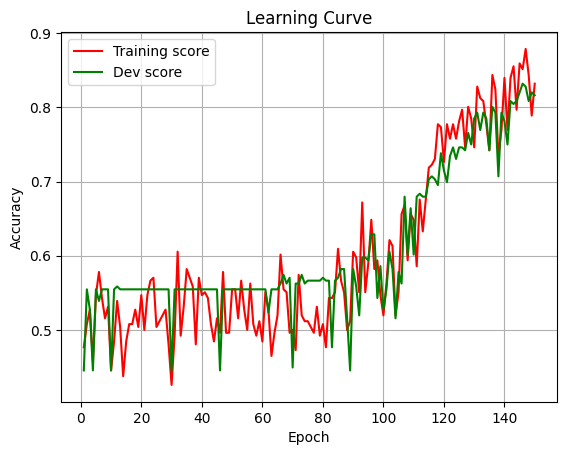

In [10]:
plt = plot_learning_curve(epochs, train_acc, dev_acc, xlab="Epoch")
plt.show()